In [2]:
import numpy as np
import cv2

In [3]:
therm = cv2.imread(r"D:\git\learning-cv\camera fusion\thermal.jpg")
ir = cv2.imread(r"D:\git\learning-cv\camera fusion\infrared.jpg")

In [19]:
therm = cv2.resize(therm, (720, 480))
ir = cv2.resize(ir, (720, 480))

In [20]:
thermGray = cv2.cvtColor(therm, cv2.COLOR_BGR2GRAY)
irGray = cv2.cvtColor(therm, cv2.COLOR_BGR2GRAY)

In [6]:
print(ir)

[[[ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]
  ...
  [ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]]

 [[ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]
  ...
  [ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]]

 [[ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]
  ...
  [ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]]

 ...

 [[123 123 123]
  [136 136 136]
  [202 202 202]
  ...
  [ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]]

 [[188 188 188]
  [182 182 182]
  [125 125 125]
  ...
  [ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]]

 [[109 109 109]
  [119 119 119]
  [115 115 115]
  ...
  [ 72  72  72]
  [ 72  72  72]
  [ 72  72  72]]]


In [5]:
fused = (ir + therm)

ValueError: operands could not be broadcast together with shapes (1280,720,3) (1599,899,3) 

In [27]:
cv2.imshow('fused', fused)

cv2.waitKey(0)

-1

In [21]:
orb = cv2.ORB_create(nfeatures=1000)

In [22]:
kp1, des1 = orb.detectAndCompute(thermGray, None)
kp2, des2 = orb.detectAndCompute(irGray, None)


In [23]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)


In [24]:
matched_img = cv2.drawMatches(therm, kp1, ir, kp2, matches[:50], None, flags=2)

# Show the result
cv2.imshow('fused', matched_img)
cv2.waitKey(0)


-1

In [25]:
# Get matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# Find homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp one image onto the other
height, width = irGray.shape
aligned_img1 = cv2.warpPerspective(thermGray, H, (width, height))

# Optional: Blend or overlay with img2
fused = cv2.addWeighted(aligned_img1, 0.5, irGray, 0.5, 0)


In [26]:
# Step 7: Warp the IR (night vision) color image to align with the thermal image and fuse them
height, width, _ = therm.shape
warped_ir = cv2.warpPerspective(ir, H, (width, height))

# Fuse the aligned IR image with the thermal image
fused = cv2.addWeighted(warped_ir, 0.5, therm, 0.5, 0)




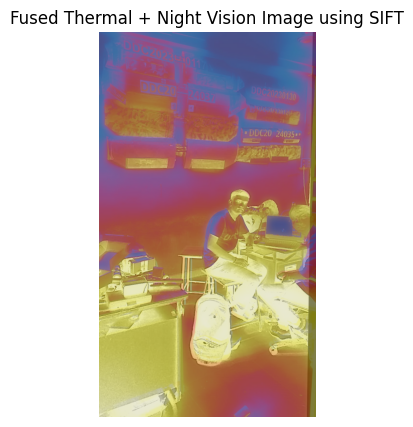

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale images for keypoint detection
thermGray = cv2.imread(r'D:\git\learning-cv\camera fusion\thermal.jpg', cv2.IMREAD_GRAYSCALE)
irGray = cv2.imread(r'D:\git\learning-cv\camera fusion\infrared.jpg', cv2.IMREAD_GRAYSCALE)

# Load original colored images for fusion
therm = cv2.imread(r'D:\git\learning-cv\camera fusion\thermal.jpg')  # Thermal image in color (pseudo-colored or colormapped)
ir = cv2.imread(r'D:\git\learning-cv\camera fusion\infrared.jpg')          # Night vision image in color

# Step 1: Initialize SIFT detector
sift = cv2.SIFT_create()

# Step 2: Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(irGray, None)
kp2, des2 = sift.detectAndCompute(thermGray, None)

# Step 3: Match descriptors using Brute-Force with L2 norm
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Step 4: Extract matched points
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Step 5: Compute Homography matrix using RANSAC
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Step 6: Warp the IR (night vision) color image to align with the thermal image
height, width, _ = therm.shape
warped_ir = cv2.warpPerspective(ir, H, (width, height))

# Step 7: Fuse the aligned IR image with the thermal image
fused = cv2.addWeighted(warped_ir, 0.5, therm, 0.5, 0)

# Step 8: Display the result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(fused, cv2.COLOR_BGR2RGB))
plt.title("Fused Thermal + Night Vision Image using SIFT")
plt.axis('off')
plt.show()
